## Train and serve a TensorFlow model with TensorFlow Serving

[Train and serve a TensorFlow model with TensorFlow Serving](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)


### 1. 引入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

# tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

2.0.0


### 2. 加载数据

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the value to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

print('train_images.shape:{}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape:(60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### 3. 训练评估模型

#### 3.1 定义 Model

In [7]:
model = keras.Sequential([
    keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3,
                        strides=2, activation='relu', name='Conv1'),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


#### 3.2 训练

In [12]:
testing = False
epochs = 5

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=epochs)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2381 - accuracy: 0.9138
Epoch 2/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.2363 - accuracy: 0.9146
Epoch 3/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.2339 - accuracy: 0.9153
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.2318 - accuracy: 0.9158
Epoch 5/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2302 - accuracy: 0.9168


In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print("Test loss: {}, test accuracy: {}".format(test_loss, test_acc))

Test loss: 0.3422777315855026, test accuracy: 0.8841000199317932


### 4. 保存 Model

我们需要把训练好的 Model 保存下来，这样才能提供服务。一般保存下来的是一个 Protobuf 文件, 而且包含 version 信息。

Tensorflow 允许我们在预测时指定不同的版本服务；不同的版本会被保存到不同的子目录中。

In [28]:
# import tempfile # This module creates temporary files and directories. It works on all supported platforms.

MODEL_DIR = './fashon'
version = 20191113

export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = ./fashon/20191113


Saved model:
total 144
drwxr-xr-x  2 eason  staff     64 Nov 13 15:30 assets
-rw-r--r--  1 eason  staff  73477 Nov 13 15:30 saved_model.pb
drwxr-xr-x  4 eason  staff    128 Nov 13 15:30 variables


#### 5. 检查保存的模型

`saved_model_cli` 可以查看出模型的定义信息：`MetaGraphDefs` 和可以调用的信息: `SignatureDefs`.

In [29]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


#### 6. Serving 服务

本地就不用编译 `tensorflow-model-server` 了太费劲。直接用 Docker 镜像来搞。

```bash
# Download the TensorFlow Serving Docker image and repo
docker pull tensorflow/serving

docker run -t --rm -p 8501:8501 \
    -v "~/04-serving/fashon:/models/fashion" \
    -e MODEL_NAME=fashion \
    tensorflow/serving 

2019-11-13 07:32:59.778625: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:151] Running initialization op on SavedModel bundle at path: /models/fashion/20191113
2019-11-13 07:32:59.783224: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 109136 microseconds.
2019-11-13 07:32:59.784041: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /models/fashion/20191113/assets.extra/tf_serving_warmup_requests
2019-11-13 07:32:59.800416: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion version: 20191113}
2019-11-13 07:32:59.802784: I tensorflow_serving/model_servers/server.cc:353] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
2019-11-13 07:32:59.805188: I tensorflow_serving/model_servers/server.cc:373] Exporting HTTP/REST API at:localhost:8501 ...
[evhttp_server.cc : 238] NET_LOG: Entering the event loop ...
```

看下启动信息，我们可以看到时：

- Successfully loaded servable version {name: fashion version: 20191113}
- Running gRPC ModelServer at 0.0.0.0:8500 ...
- Exporting HTTP/REST API at:localhost:8501 ...

可以看到 `model_server/server.cc` 文件

- 2019-11-13 07:32:59.805188: I tensorflow_serving/model_servers/server.cc:373]

服务启动了，就可来预测了...

### 7. 预测服务

使用预测服务，样本的特征数据还是需要我们提供的。所以先来构建下特征数据。

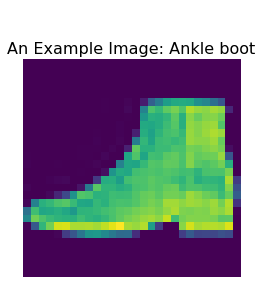

In [31]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show(idx, title):
    plt.figure()
    plt.imshow(test_images[idx].reshape(28, 28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0, len(test_images) - 1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))


构建我们的请求数据。

In [35]:
import json
data = json.dumps({
    "signature_name": "serving_default",
    "instances": test_images[0:3].tolist()
})
print('Data: {} ... {}'.format(data[:80], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.0] ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


<Response [200]>


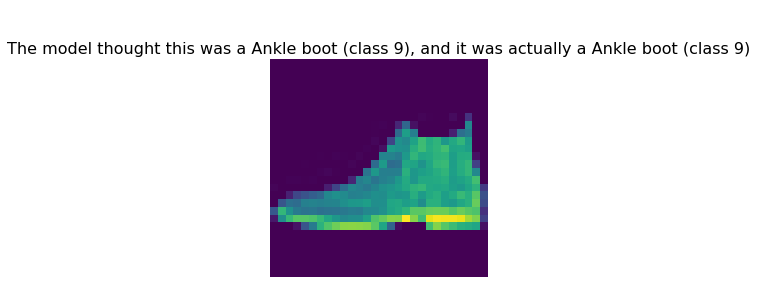

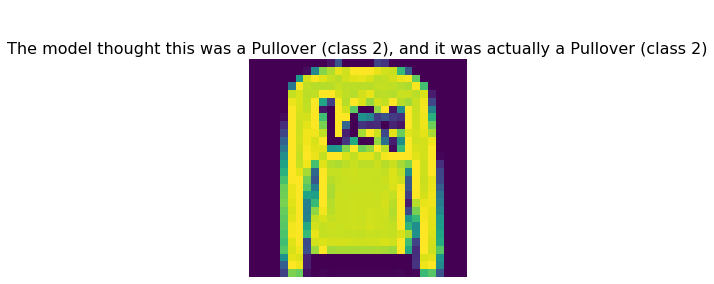

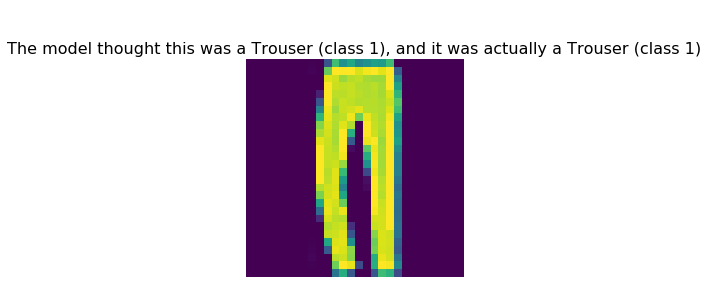

In [39]:
import requests
headers = {"content-type": "application/json"}
url = 'http://localhost:8501/v1/models/fashion:predict'
json_response = requests.post(url, data=data, headers=headers)

print(json_response)

predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
    show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], test_labels[i], class_names[np.argmax(predictions[i])], test_labels[i]))


### 8. Todo

- [ ] 谁来获取特征那？特征不应该用预测服务器来做预测...
- [ ] 预测服务器只用做预测...
- [ ] 特征应该有调用方来提供...
- [ ] 应该单独的搞个特征服务器... 